In [1]:
from transformers import LlamaForCausalLM, LlamaTokenizer
from transformers import MBartForConditionalGeneration, AutoModelForSeq2SeqLM
from transformers import AlbertTokenizer, AlbertForMaskedLM
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch
from transformers import AutoTokenizer, DataCollatorForSeq2Seq
from torch.utils.data import DataLoader

/home2/likhithasapu/miniconda3/envs/research/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

tokenizer = AutoTokenizer.from_pretrained("ai4bharat/IndicBART", do_lower_case=False, use_fast=False, keep_accents=True)

# tokenizer = AlbertTokenizer.from_pretrained("ai4bharat/IndicBART", do_lower_case=False, use_fast=False, keep_accents=True)

model = AutoModelForSeq2SeqLM.from_pretrained("ai4bharat/IndicBART", device_map="auto")
# model = torch.nn.DataParallel(model)

# model = MBartForConditionalGeneration.from_pretrained("ai4bharat/IndicBART")

# Some initial mapping
bos_id = tokenizer._convert_token_to_id_with_added_voc("<s>")
eos_id = tokenizer._convert_token_to_id_with_added_voc("</s>")
pad_id = tokenizer._convert_token_to_id_with_added_voc("<pad>")
# To get lang_id use any of ['<2as>', '<2bn>', '<2en>', '<2gu>', '<2hi>', '<2kn>', '<2ml>', '<2mr>', '<2or>', '<2pa>', '<2ta>', '<2te>']

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
from datasets import load_dataset
from huggingface_hub import login

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home2/likhithasapu/.cache/huggingface/token
Login successful


In [4]:
data = load_dataset("prakod/gcm_enhi_with_cmi_ratings_gt_4_cmi_gt_10_allperidx",split="train",use_auth_token=True,cache_dir="codemix-dataset").train_test_split(test_size=0.2,shuffle=True)

/home2/likhithasapu/miniconda3/envs/research/lib/python3.11/site-packages/datasets/load.py:2069: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=True' instead.
  warnings.warn(


In [5]:
data['test'][0]

{'uid': 'gcm_7186533',
 'idx': 633064,
 'cmi': 14.2857142857,
 'acceptability_ratings': 4.576805114746094,
 'L1': 'उस वक्त वहां भारी बारिश हो रही थी।',
 'L2': 'It was raining heavily at that time .',
 'CM_candidates': 'उस वक्त heavily बारिश हो रही थी।',
 'CM_candidates_transliterated_indictrans': 'us vakt heavily barish ho rahi thi.'}

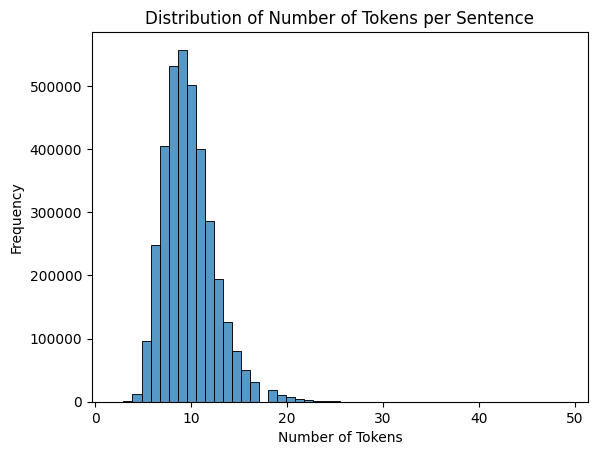

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
# Tokenize the sentences and get the number of tokens
num_tokens = [len(tokenizer.tokenize(sentence)) for sentence in data['train']['CM_candidates']]

# Plotting the distribution of the number of tokens
sns.histplot(num_tokens, bins=50)
plt.title("Distribution of Number of Tokens per Sentence")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

In [7]:
# Iterate through the dataset
max_length = 0
for sentence in data['train']['CM_candidates']:
    tokenized_sentence = tokenizer.tokenize(sentence)
    length = len(tokenized_sentence)
    
    if length > max_length:
        max_length = length
        max_sentence = sentence

# Output the sentence with the maximum length and the number of tokens
print(f"Sentence with the maximum number of tokens ({max_length} tokens):")
print(max_sentence)

Sentence with the maximum number of tokens (49 tokens):
This road is part of the high-density यातायात corridor Banglore-Chitradurga-Bijapur-Solapur-Aurangabad-Dhule-lndore-Gwalior


In [11]:
def preprocess_function(examples):
    prompts = [f"Translate the English sentence to Hindi-English sentence: <2en> <s> {example} </s> \n\n <2hien>" for example in examples['L2']]
    responses = [f"<s> {example} </s>" for example in examples['CM_candidates']]
    model_inputs = tokenizer(prompts,truncation=True, padding=True,max_length=128, return_tensors="pt")
    model_inputs["labels"] = tokenizer(responses,truncation=True, padding=True,max_length=128, return_tensors="pt")["input_ids"]
    
    return{
        "input_ids": model_inputs.input_ids.to("cuda"),
        "attention_mask": model_inputs.attention_mask.to("cuda"),
        "labels": model_inputs.labels.to("cuda")
    }
    
# Apply the preprocess function to the dataset with batching
batch_size = 64
processed_data = data.map(
    preprocess_function,
    batched=True,
    batch_size=batch_size,
    remove_columns=data["train"].column_names
)

Map:  16%|█▌        | 557440/3569865 [02:30<13:17, 3779.52 examples/s]

In [ ]:
processed_data['train']

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 3569865
})

In [ ]:
import wandb

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: likhithasapu (cmacc). Use `wandb login --relogin` to force relogin


True

In [ ]:
# use blue score as metric

from datasets import load_metric
metric = load_metric("sacrebleu")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    return result

/tmp/ipykernel_9860/1730012581.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("sacrebleu")


In [ ]:

from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

training_args = Seq2SeqTrainingArguments(
    output_dir="/scratch/likhithasapu/results-codemix-indicbart",
    learning_rate=2e-5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    report_to="wandb",
    run_name="codemix-indicbart",
    load_best_model_at_end=True,
    fp16=True,
    predict_with_generate=True,
    logging_steps=1000
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=processed_data['train'],
    eval_dataset=processed_data['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

Detected kernel version 4.15.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.22 GiB. GPU 0 has a total capacity of 10.75 GiB of which 1.14 GiB is free. Including non-PyTorch memory, this process has 9.61 GiB memory in use. Of the allocated memory 8.21 GiB is allocated by PyTorch, and 633.45 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
tokenizer.push_to_hub("gcm_codemix_indicbart_cmi_ratings_gt_4_cmi_gt_10_allperidx")
model.push_to_hub("gcm_codemix_indicbart_cmi_ratings_gt_4_cmi_gt_10_allperidx")

: 